In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import time

In [2]:
data=pd.read_excel(r'D:\Documents\samoray\Рабочий стол\Сводный_файл_с_результатами_июль_август_2023.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51027 entries, 0 to 51026
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Телефон             51027 non-null  int64  
 1   ID задания          51027 non-null  int64  
 2   № перезвона         0 non-null      float64
 3   Статус задания      51027 non-null  object 
 4   Дата создания       51027 non-null  object 
 5   Дата завершения     42178 non-null  object 
 6   Количество звонков  51027 non-null  int64  
 7   Длительность        42178 non-null  object 
 8   Последняя попытка   42178 non-null  object 
 9   Последняя метка     22928 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 3.9+ MB


In [4]:
# Преобразуем формат времени
data['Дата завершения'] = pd.to_datetime(data['Дата завершения'], dayfirst=True)
data['Длительность'] = pd.to_timedelta(data['Длительность'])
data['Дата звонка']=data['Дата завершения']-data['Длительность']

In [5]:
data['Год звонка'] = data['Дата звонка'].dt.year
data['Месяц звонка'] = data['Дата звонка'].dt.month
data['День недели звонка'] = data['Дата звонка'].dt.dayofweek

In [6]:
# data[['Дата звонка','Длительность','Дата завершения']].head(50)

In [7]:
data=data[pd.isna(data['Длительность'])==False]

In [8]:
data['Телефон'] = data['Телефон'].astype( str )
def number(row):
    if row['Телефон'][:2]=='79':
        return 'Мобильный'
    else:
        return 'Стационарный'

data['Тип телефона'] = data.apply(number, axis=1) 

In [9]:
def result_f(row):
    if row['Статус задания']=='Завершен' and row['Последняя метка']=='Автоответчик':
        return 'Не дозвонились'
    elif row['Статус задания']=='Завершен' and row['Последняя метка']=='Отказ':
        return 'Дозвонились'
    elif row['Статус задания']=='Завершен' and row['Последняя метка']=='Предложение' and row['Длительность']<=pd.Timedelta(minutes=1):
        return 'Дозвонились'
    elif row['Статус задания']=='Завершен' and row['Последняя метка']=='Предложение' and row['Длительность']>pd.Timedelta(minutes=1):
        return 'Не дозвонились'
    elif row['Статус задания']=='Завершен' and row['Последняя метка']=='Согласие':
        return 'Дозвонились'
    elif row['Статус задания']=='Завершен без ответа' and pd.isna(row['Последняя метка'])==True:
        return 'Не дозвонились'
    elif row['Статус задания']=='Завершен с технической ошибкой' and pd.isna(row['Последняя метка'])==True:
        return 'Ошибка'
    elif row['Статус задания']=='Завершен' and row['Последняя метка']=='Информатор':
        return 'Дозвонились'
data['Результат звонка'] = data.apply(result_f, axis=1) 

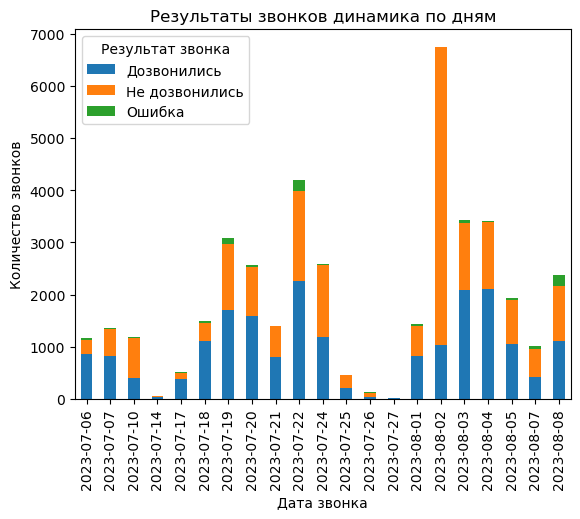

In [10]:
daily_counts = data.groupby(data['Дата звонка'].dt.date)['Результат звонка'].value_counts().unstack(fill_value=0)

# Диаграмма
daily_counts.plot(kind='bar', stacked=True)

plt.xlabel('Дата звонка')
plt.ylabel('Количество звонков')
plt.title('Результаты звонков динамика по дням')

plt.show()

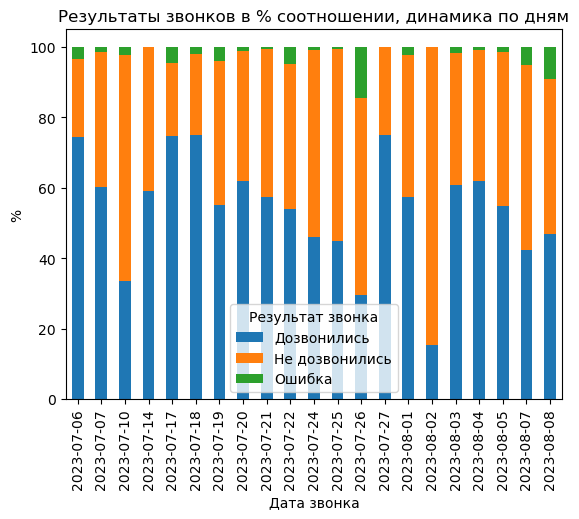

In [11]:
daily_counts = data.groupby(data['Дата звонка'].dt.date)['Результат звонка'].value_counts(normalize=True).unstack(fill_value=0)

daily_counts['Дозвонились']=round(daily_counts['Дозвонились']*100,2)
daily_counts['Не дозвонились']=round(daily_counts['Не дозвонились']*100,2)
daily_counts['Ошибка']=round(daily_counts['Ошибка']*100,2)

# Диаграмма
ax = daily_counts.plot(kind='bar', stacked=True)

plt.xlabel('Дата звонка')
plt.ylabel('%')
plt.title('Результаты звонков в % соотношении, динамика по дням')

plt.show()

# Стистика результатов звонка по месяцам

In [12]:
count_res=data.groupby(['Год звонка','Месяц звонка','Результат звонка'],as_index=False) \
.aggregate({'Телефон':"count"}) \
.rename(columns={"Телефон":"Количество"}) \
.sort_values(by=['Год звонка','Месяц звонка'], ascending=False)

count_res_sum=count_res.groupby(['Год звонка','Месяц звонка'],as_index=False) \
.aggregate({'Количество':"sum"}) \
.rename(columns={"Количество":"Количество месяц"}) \
.sort_values(by=['Год звонка','Месяц звонка'], ascending=False)

df_year_month_res=count_res.merge(count_res_sum,how = 'left',
                 left_on=['Год звонка','Месяц звонка'], 
                 right_on=['Год звонка','Месяц звонка'])

df_year_month_res['%']=round((df_year_month_res['Количество']*100)/df_year_month_res['Количество месяц'],2)

df_year_month_res[['Год звонка','Месяц звонка','Результат звонка','Количество','%']].head(50)

,Год звонка,Месяц звонка,Результат звонка,Количество,%
0,2023.0,8.0,Дозвонились,8664,42.58
1,2023.0,8.0,Не дозвонились,11261,55.34
2,2023.0,8.0,Ошибка,423,2.08
3,2023.0,7.0,Дозвонились,11410,56.51
4,2023.0,7.0,Не дозвонились,8242,40.82
5,2023.0,7.0,Ошибка,538,2.66


In [13]:
# count_2023=df_year_month_res.loc[((df_year_month_res['Год звонка']== 2023) & 
#                                   (df_year_month_res['Результат звонка']=='Дозвонились'))]
# count_2022=df_year_month_res.loc[((df_year_month_res['Год звонка']== 2022) & 
#                                   (df_year_month_res['Результат звонка']=='Дозвонились'))] 
# width = 0.50

# month=['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

# plt.figure(figsize=(10, 6))
# plt.bar(count_2023['Месяц звонка']-0.25, count_2023['Количество'], width, label='Кол-во дозвон за 2023')
# # plt.bar(count_2022['Месяц звонка']+0.25, count_2022['Количество'], width, label='Кол-во дозвон за 2022')

# plt.xticks([12,11,10,9,8,7,6,5,4,3,2,1],month[::-1])

# plt.xlabel("Номер месяца")
# plt.ylabel("Кол-во ")
# plt.legend(["Кол-во за 2023", "Кол-во за 2022"])
# plt.title('Количество дозвонившихся в разрезе по месяцам за 2023 год', fontsize=15)
# plt.show()

# Статистика по дозвонившимся (Октел плюс)

# Тип телефона

In [14]:
df_true=data[data['Результат звонка']=='Дозвонились']

df_true_t_f=df_true.groupby(['Тип телефона'],as_index=False) \
.aggregate({'Результат звонка':"count"}) \
.rename(columns={"Результат звонка":"Количество"}) 
df_true_t_f

,Тип телефона,Количество
0,Мобильный,11345
1,Стационарный,8729


([<matplotlib.patches.Wedge at 0xc70dcd2730>,
 [Text(-0.2236037190835739, 1.0770336005956334, 'Мобильный'),
  Text(0.24393132990935346, -1.1749457461043273, 'Стационарный')],
 [Text(-0.12196566495467666, 0.5874728730521636, '56.5%'),
  Text(0.1422932757804562, -0.6853850185608575, '43.5%')])

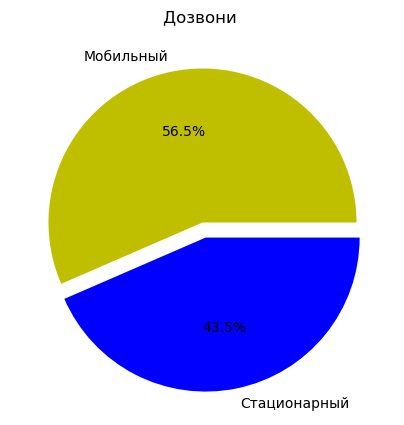

In [15]:
plt.figure(figsize=(5, 5))
values=df_true_t_f['Количество']
name=df_true_t_f['Тип телефона']
colors=["y","b"]
plt.title("Дозвон")
explode=[0,0.1]
plt.pie(values,colors=colors,labels=name,explode=explode,autopct='%1.1f%%')

# День недели

In [16]:
df_true_d=df_true.groupby(['День недели звонка'],as_index=False) \
.aggregate({'Результат звонка':"count"}) \
.rename(columns={"Результат звонка":"Количество"}) \
.sort_values(by='Количество', ascending=False)
df_true_d

,День недели звонка,Количество
3,3.0,4555
4,4.0,3757
5,5.0,3315
1,1.0,3263
2,2.0,2774
0,0.0,2410


In [17]:
print('0 - Понедельник, 1 - Вторник и т.д' )

0 - Понедельник, 1 - Вторник и т.д


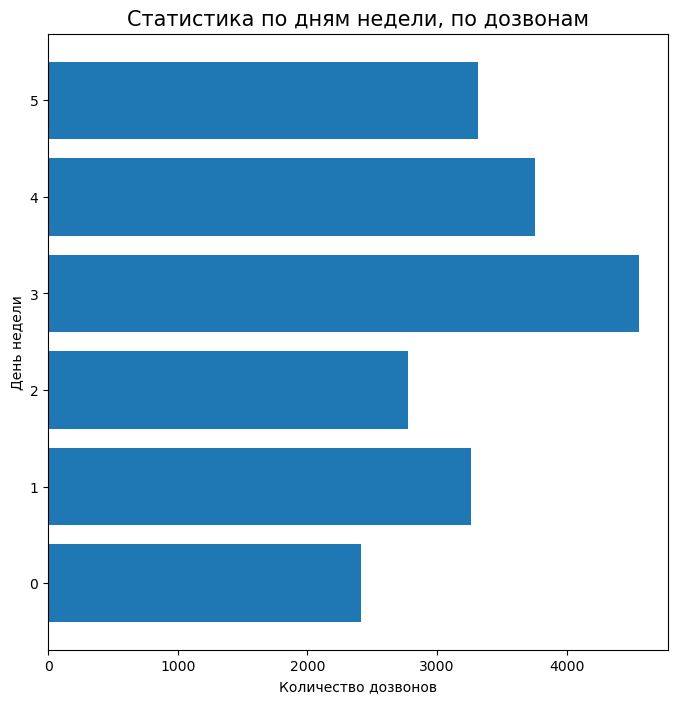

In [18]:
plt.figure(figsize=(8, 8))
plt.barh(df_true_d['День недели звонка'], df_true_d['Количество'], label='КЛвК')
plt.xlabel("Количество дозвонов")
plt.ylabel("День недели")
plt.title('Статистика по дням недели, по дозвонам', fontsize=15)
plt.show()

# По времени звонка

In [19]:
df_true_1= df_true[df_true['Дата звонка'].dt.time < time(14, 0)]
df_true_2= df_true[df_true['Дата звонка'].dt.time > time(14, 0)]

([<matplotlib.patches.Wedge at 0xc70d49e580>,
 [Text(0.2294269055964887, 1.0758082054847975, 'До 14:00'),
  Text(-0.250283897014352, -1.1736089514379606, 'После 14:00')],
 [Text(0.12514194850717564, 0.5868044757189803, '43.3%'),
  Text(-0.14599893992503865, -0.6846052216721437, '56.7%')])

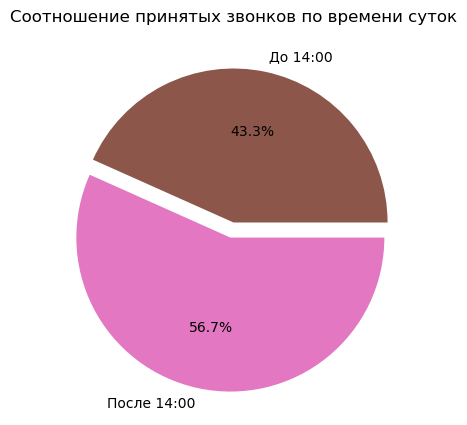

In [20]:
plt.figure(figsize=(5, 5))
values=[df_true_1['Результат звонка'].count(),df_true_2['Результат звонка'].count()]
name=['До 14:00','После 14:00']
colors=['tab:brown', 'tab:pink']
plt.title("Cоотношение принятых звонков по времени суток")
explode=[0,0.1]
plt.pie(values,colors=colors,labels=name,explode=explode,autopct='%1.1f%%')